In [1]:
from DiffGSP.DiffGSP import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams.update({'font.size': 18})

/home/sunshuli/anaconda3/envs/DiffGSP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_names = np.loadtxt('data/10x_visium_datasets.txt', dtype=str)
data_name = data_names[8]
print(data_name)
adata = sc.read_visium('/storage/sunshuli/datasets/Visium/' + data_name,
                       count_file=data_name + '_raw_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata

1.1.0_V1_Adult_Mouse_Brain


AnnData object with n_obs × n_vars = 4992 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
mito_genes = adata.var_names.str.startswith('mt-')
adata = adata[:, ~mito_genes]
adata = adata[:, prefilter_genes(adata, min_cells=3)]
svgs = select_svgs(adata, svg_method='gft_top', n_top=2000)
adata = adata[:, svgs]
adata_raw = adata.copy()
adata_raw.write_h5ad(f'results/Visium/{data_name}_raw.h5ad')
adata

View of AnnData object with n_obs × n_vars = 4992 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
import time
start_time = time.time()
k = 2
adata, optimal_solution, loss_list, constant = DiffGSP(adata, k=k, alpha=0, device=device, method='BFGS', max_iter=20, data_type='Visium')
end_time = time.time()
print(end_time - start_time)
adata.write_h5ad(f'results/Visium/{data_name}_DiffGSP.h5ad')
optimal_solution

Training:  13%|█▋           | 13/100 [00:38<04:14,  2.93s/it, Loss=tensor(21.0749, device='cuda:0')]


61.40852236747742


tensor([0.2811, 0.1664], device='cuda:0', dtype=torch.float64)

In [10]:
adata_raw = sc.read_h5ad(f'results/Visium/{data_name}_raw.h5ad')
adata = sc.read_h5ad(f'results/Visium/{data_name}_DiffGSP.h5ad')
sc.pp.log1p(adata_raw)
sc.pp.log1p(adata)

coor = adata.obs[['array_row', 'array_col']]
nbrs = NearestNeighbors(n_neighbors=6)
nbrs.fit(coor)
distances, indices = nbrs.kneighbors(coor)
counts = np.bincount(np.concatenate(indices[adata.obs['in_tissue'] == 0]))
index_edge = np.where((counts >= 1) & (counts <= 3))[0]
adata.obs['edge'] = np.nan
adata.obs['edge'].iloc[index_edge] = 'edge'
adata.obs['edge'].iloc[adata.obs['in_tissue'] == 0] = np.nan
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]
adata_raw.obsm['spatial'][:, 1] = -adata_raw.obsm['spatial'][:, 1]
adata_raw.obs['edge'] = adata.obs['edge']

for gene_temp in adata.var_names[[0, 1, 3]]:
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    sc.pl.spatial(adata_raw, color=gene_temp, ax=ax, colorbar_loc=None, title='', show=False, cmap='jet', spot_size=130)
    adata_raw.uns['edge_colors'] = ['#ffffff']
    sc.pl.spatial(adata_raw, color='edge', spot_size=150, ax=ax, legend_loc=None, title='', show=False,
                  save=f'Visium/{data_name}/gene_{gene_temp}_raw.pdf')
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    sc.pl.spatial(adata, color=gene_temp, ax=ax, colorbar_loc=None, title='', show=False, cmap='jet', spot_size=130)
    adata.uns['edge_colors'] = ['#ffffff']
    sc.pl.spatial(adata, color='edge', spot_size=150, ax=ax, legend_loc=None, title='', show=False,
                  save=f'Visium/{data_name}/gene_{gene_temp}_DiffGSP.pdf')

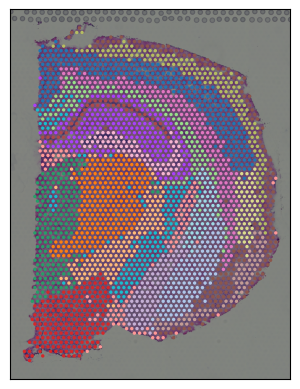

In [4]:
if not os.path.exists('figures/showVisium/' + data_name):
    os.mkdir('figures/showVisium/' + data_name)
adata_raw = sc.read_h5ad(f'results/Visium/{data_name}_raw.h5ad')
adata_raw = adata_raw[adata_raw.obs['in_tissue'] == 1, :]
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
sc.tl.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.leiden(adata_raw, resolution=1.0)
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
sc.pl.spatial(adata_raw, color='leiden', title='', legend_loc=None, ax=ax, save=f'Visium/{data_name}/leiden_raw.pdf')
adata_raw.obs['leiden'].to_csv(f'results/Visium/{data_name}_leiden_raw.csv')

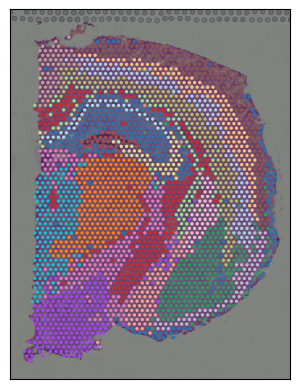

In [5]:
adata = sc.read_h5ad(f'results/Visium/{data_name}_DiffGSP.h5ad')
adata = adata[adata.obs['in_tissue'] == 1, :]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.9)
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
sc.pl.spatial(adata, color='leiden', title='', legend_loc=None, ax=ax, save=f'Visium/{data_name}/leiden_DiffGSP.pdf')
# adata.obs['leiden'].to_csv(f'results/Visium/{data_name}_leiden_DiffGSP.csv')

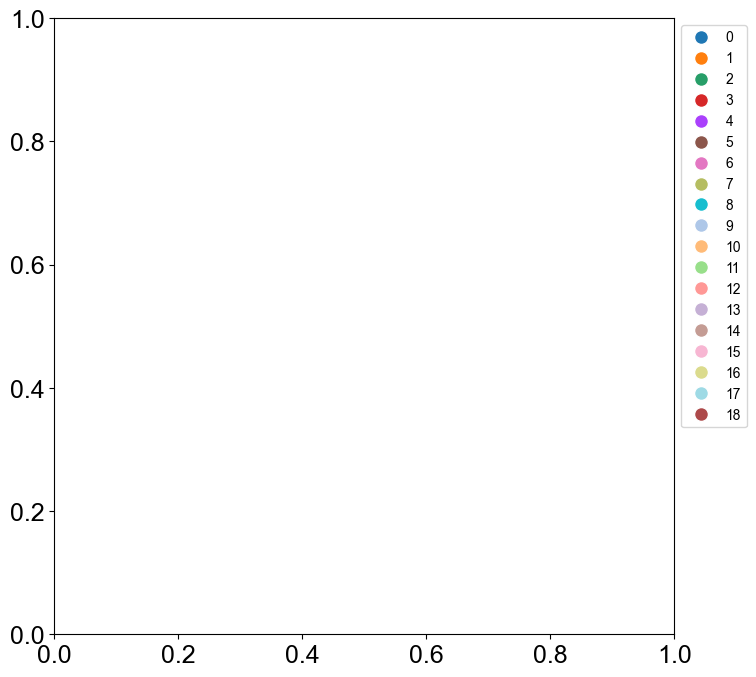

In [6]:
plt.figure(figsize=(8, 8))
colors = []
for c in adata.uns['leiden_colors']:
    colors.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10))
plt.legend(colors, [i for i in range(len(adata.uns['leiden_colors']))], fontsize=10,
           loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.savefig(f'figures/showVisium/{data_name}/leiden_legend.pdf')
plt.show()

In [3]:
adata_raw = sc.read_h5ad(f'results/Visium/{data_name}_raw.h5ad')
adata_raw = adata_raw[adata_raw.obs['in_tissue'] == 1, :]
# adata_raw.obs['leiden'] = pd.read_csv(f'results/Visium/{data_name}_leiden_raw.csv', index_col=0)
adata = sc.read_h5ad(f'results/Visium/{data_name}_DiffGSP.h5ad')
adata = adata[adata.obs['in_tissue'] == 1, :]
adata.obs['leiden'] = pd.read_csv(f'results/Visium/{data_name}_leiden_DiffGSP.csv', index_col=0, dtype=str)

# DiffGSP
adata = adata[(adata.obs['leiden'] == '16') | (adata.obs['leiden'] == '18'), :]
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata,
                        groupby='leiden',
                        method='wilcoxon')
groups = adata.uns['rank_genes_groups']['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: adata.uns['rank_genes_groups'][key][group]
    for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})
degs_sig = degs[(degs['16_pvals_adj'] < 0.05) & (degs['18_pvals_adj'] < 0.05)]
degs_list = np.concatenate([degs_sig['16_names'][:200].values, degs_sig['18_names'][:200].values])
degs_DiffGSP = degs[degs['16_names'].isin(degs_list)]
degs_DiffGSP.index = degs_DiffGSP['16_names'].values
degs_DiffGSP = degs_DiffGSP[['16_pvals', '16_logfoldchanges']]
degs_DiffGSP = degs_DiffGSP.rename(columns={'16_pvals': '16_pvals_DiffGSP', '16_logfoldchanges': '16_logfoldchanges_DiffGSP'})

# Raw
adata_raw.obs['leiden'] = adata.obs['leiden']
adata_raw = adata_raw[(adata_raw.obs['leiden'] == '16') | (adata_raw.obs['leiden'] == '18'), :]
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
sc.tl.rank_genes_groups(adata_raw,
                        groupby='leiden',
                        method='wilcoxon')
groups = adata_raw.uns['rank_genes_groups']['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: adata_raw.uns['rank_genes_groups'][key][group]
    for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})
degs_raw = degs[degs['16_names'].isin(degs_list)]
degs_raw.index = degs_raw['16_names'].values
degs_raw = degs_raw[['16_pvals', '16_logfoldchanges']]
degs_raw = degs_raw.rename(columns={'16_pvals': '16_pvals_raw', '16_logfoldchanges': '16_logfoldchanges_raw'})

degs_merged = pd.merge(degs_DiffGSP, degs_raw, left_index=True, right_index=True)

In [4]:
degs_merged

,16_pvals_DiffGSP,16_logfoldchanges_DiffGSP,16_pvals_raw,16_logfoldchanges_raw
Selenow,3.365773e-12,1.109950,3.655283e-12,0.794766
Cpe,3.365773e-12,2.041540,2.416370e-12,1.272709
Nrip3,1.344184e-11,3.039586,5.511082e-12,2.106080
Bok,2.865939e-11,3.637398,2.171360e-11,2.620791
Sv2b,1.641721e-10,4.561825,7.635750e-12,3.539852
...,...,...,...,...
Pitpnm2,5.166320e-11,-3.598167,3.927874e-11,-3.086201
Adcy1,3.490853e-11,-3.616725,1.344184e-11,-2.536941
Eef1a1,8.980764e-12,-1.086618,3.365773e-12,-0.765006
Ppp1r1a,7.039381e-12,-2.475674,2.625611e-12,-1.866274


In [5]:
# selected_rows = degs_merged[degs_merged['16_pvals_DiffGSP'] < degs_merged['16_pvals_raw']]
selected_rows = degs_merged[(degs_merged['16_pvals_DiffGSP'] < 0.5 * degs_merged['16_pvals_raw']) & 
                            (degs_merged['16_logfoldchanges_DiffGSP'].abs() > degs_merged['16_logfoldchanges_raw']).abs() &
                            (degs_merged['16_pvals_raw'] < 0.05)]
selected_rows['16_pvals_DiffGSP'] = - np.log10(selected_rows['16_pvals_DiffGSP'])
selected_rows['16_pvals_raw'] = - np.log10(selected_rows['16_pvals_raw'])
selected_rows

,16_pvals_DiffGSP,16_logfoldchanges_DiffGSP,16_pvals_raw,16_logfoldchanges_raw
Cnih2,5.871193,0.885293,4.763387,0.468243
Calm3,5.744980,0.418561,5.206463,0.328040
Shisa6,5.170743,1.684884,4.683987,1.377630
Aldoa,5.158864,0.787310,4.786199,0.415205
Cpne6,3.497265,0.986835,2.495944,0.545682
Camta2,3.429610,0.575572,2.134411,0.289606
Dynll1,2.816340,0.594488,1.942711,0.282335
Rps27,4.063058,-0.847151,3.362634,-0.412652
Penk,7.787499,-4.368327,7.127045,-2.747296


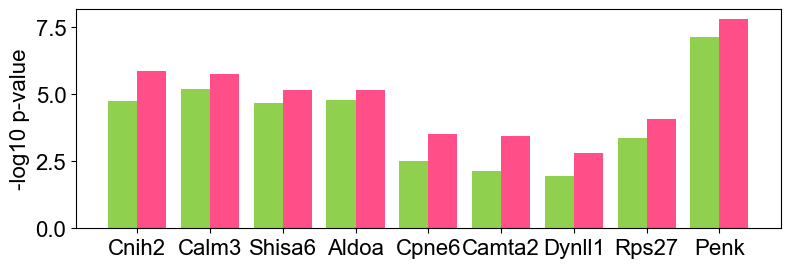

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
df = selected_rows

fig, ax = plt.subplots(figsize=(8, 3))
gene_positions = np.arange(len(df)) * 1
raw_positions = gene_positions - 0.2
diffgsp_positions = gene_positions + 0.2
# ax.bar(raw_positions, df['16_pvals_raw'], width=0.4, align='center', color='skyblue', label='16_pvals_raw')
# ax.bar(diffgsp_positions, df['16_pvals_DiffGSP'], width=0.4, align='center', color='lightcoral', label='16_pvals_DiffGSP')
ax.bar(raw_positions, df['16_pvals_raw'], width=0.4, align='center', color='#8FD14F', label='16_pvals_raw')
ax.bar(diffgsp_positions, df['16_pvals_DiffGSP'], width=0.4, align='center', color='#FF4E88', label='16_pvals_DiffGSP')
ax.set_xticks(gene_positions)
ax.set_xticklabels(df.index)
# ax.set_xlabel('gene')
ax.set_ylabel('-log10 p-value')
# ax.legend()
plt.tight_layout()
# plt.title('每个基因的 raw 和 DiffGSP 状态下的16_pvals 柱状图')
plt.savefig(f'figures/showVisium/{data_name}/DEG_pvalue.pdf')
plt.show()

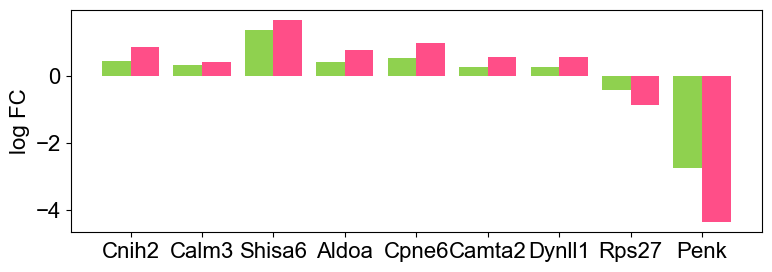

In [7]:
fig, ax = plt.subplots(figsize=(8, 3))
gene_positions = np.arange(len(df)) * 1
raw_positions = gene_positions - 0.2
diffgsp_positions = gene_positions + 0.2
# ax.bar(raw_positions, df['16_logfoldchanges_raw'], width=0.4, align='center', color='skyblue', label='16_pvals_raw')
# ax.bar(diffgsp_positions, df['16_logfoldchanges_DiffGSP'], width=0.4, align='center', color='lightcoral', label='16_pvals_DiffGSP')
ax.bar(raw_positions, df['16_logfoldchanges_raw'], width=0.4, align='center', color='#8FD14F', label='16_pvals_raw')
ax.bar(diffgsp_positions, df['16_logfoldchanges_DiffGSP'], width=0.4, align='center', color='#FF4E88', label='16_pvals_DiffGSP')
ax.set_xticks(gene_positions)
ax.set_xticklabels(df.index)
# ax.set_xlabel('gene')
ax.set_ylabel('log FC')
# ax.legend()
plt.tight_layout()
# plt.title('每个基因的 raw 和 DiffGSP 状态下的16_pvals 柱状图')
plt.savefig(f'figures/showVisium/{data_name}/DEG_logFC.pdf')
plt.show()

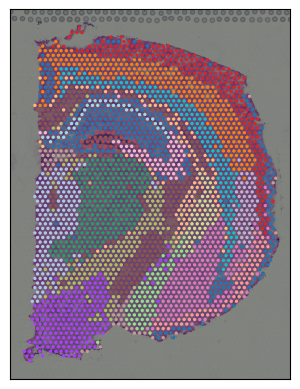

In [13]:
adata_raw = sc.read_h5ad(f'results/Visium/{data_name}_raw.h5ad')
counts_SpotClean = pd.read_csv(f'SpotClean_results/{data_name}_raw.csv', index_col=0)
counts_SpotClean.index = [i.replace('.', '-') for i in counts_SpotClean.index]
adata_raw = adata_raw[adata_raw.obs['in_tissue'] == 1, :]
adata_SpotClean = adata_raw.copy()
counts_SpotClean = counts_SpotClean.loc[adata_SpotClean.obs_names, adata_SpotClean.var_names]
adata_SpotClean.X = counts_SpotClean

sc.pp.normalize_total(adata_SpotClean)
sc.pp.log1p(adata_SpotClean)
sc.tl.pca(adata_SpotClean)
sc.pp.neighbors(adata_SpotClean)
sc.tl.leiden(adata_SpotClean, resolution=0.93)
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
sc.pl.spatial(adata_SpotClean, color='leiden',  title='', legend_loc=None, ax=ax, save=f'Visium/{data_name}/SpotClean_leiden.pdf')

In [14]:
adata_raw = sc.read_h5ad(f'results/Visium/{data_name}_raw.h5ad')
counts_SpotClean = pd.read_csv(f'SpotClean_results/{data_name}_raw.csv', index_col=0)
counts_SpotClean.index = [i.replace('.', '-') for i in counts_SpotClean.index]
adata_raw = adata_raw[adata_raw.obs['in_tissue'] == 1, :]
adata_SpotClean = adata_raw.copy()
counts_SpotClean = counts_SpotClean.loc[adata_SpotClean.obs_names, adata_SpotClean.var_names]
adata_SpotClean.X = counts_SpotClean

sc.pp.log1p(adata_SpotClean)
for gene_temp in ['Nrgn', 'Sparc', 'Camk2n1']:
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    sc.pl.spatial(adata_SpotClean, color=gene_temp, spot_size=130, ax=ax, cmap='jet', title='', save=f'Visium/{data_name}/genesup_{gene_temp}_SpotClean.pdf',
                 show=False, colorbar_loc=None)

In [15]:
adata = sc.read_h5ad(f'results/Visium/{data_name}_DiffGSP.h5ad')
adata = adata[adata.obs['in_tissue'] == 1, :]
sc.pp.log1p(adata)
for gene_temp in ['Nrgn', 'Sparc', 'Camk2n1']:
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    sc.pl.spatial(adata, color=gene_temp, spot_size=130, ax=ax, cmap='jet', title='', save=f'Visium/{data_name}/genesup_{gene_temp}_DiffGSP.pdf',
                 show=False, colorbar_loc=None)

In [16]:
adata_raw = sc.read_h5ad(f'results/Visium/{data_name}_raw.h5ad')
adata_raw = adata_raw[adata_raw.obs['in_tissue'] == 1, :]
sc.pp.log1p(adata_raw)
for gene_temp in ['Nrgn', 'Sparc', 'Camk2n1']:
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    sc.pl.spatial(adata_raw, color=gene_temp, spot_size=130, ax=ax, cmap='jet', title='', save=f'Visium/{data_name}/genesup_{gene_temp}_raw.pdf',
                 show=False, colorbar_loc=None)